# Import required libraries

In [593]:
import pandas as pd
import numpy as np
import torch
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import LabelEncoder

# Import data

In [594]:
# data url
train_data_url = "./data/train.csv"
test_data_url = "./data/test.csv"

In [595]:
# converting df
train_df = pd.read_csv(train_data_url)
test_df = pd.read_csv(test_data_url)

# Visualize data

In [596]:
# train dataframe
train_df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [597]:
# test dataframe
test_df

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


# Data error correction

In [598]:
train_df["num_sold"] = train_df["num_sold"].fillna(train_df["num_sold"].mean())

train_df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,752.527382
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.000000
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.000000
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.000000
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.000000


# Data analyse

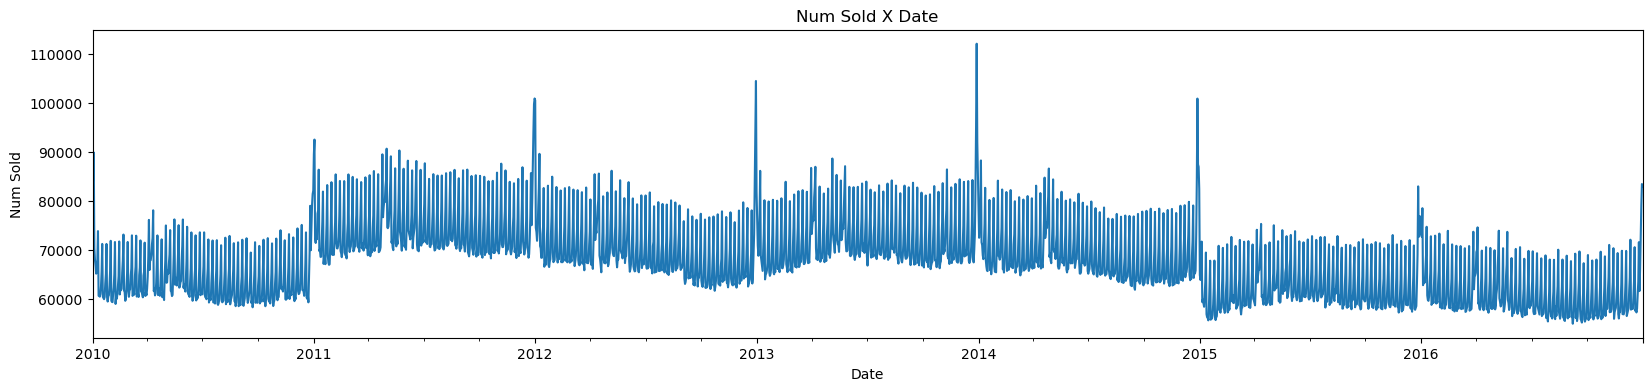

In [599]:
# understading the features of the dataframe, now we must to analyse the relationship between the features

# best seller year
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
train_df.groupby("date")["num_sold"].sum().plot(figsize=(20, 4))

plt.title("Num Sold X Date")
plt.xlabel("Date")
plt.ylabel("Num Sold")
plt.show()

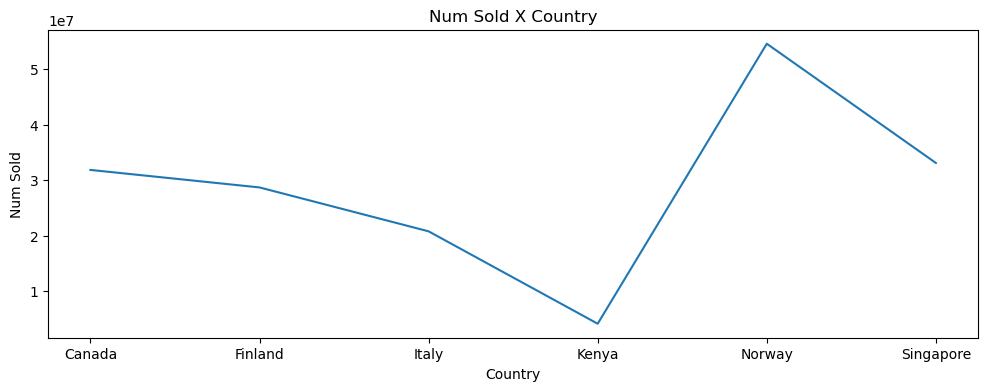

In [600]:
# best seller country
train_df.groupby("country")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Country")
plt.xlabel("Country")
plt.ylabel("Num Sold")
plt.show()

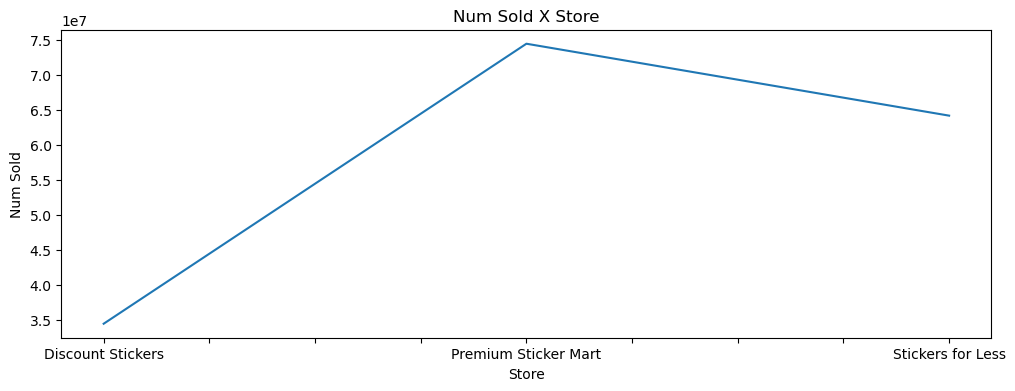

In [601]:
# best seller store
train_df.groupby("store")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Store")
plt.xlabel("Store")
plt.ylabel("Num Sold")
plt.show()

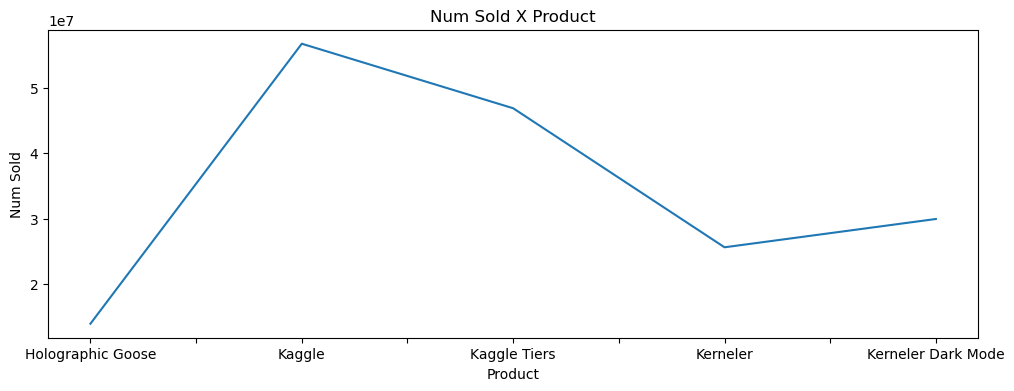

In [602]:
# best seller product
train_df.groupby("product")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Product")
plt.xlabel("Product")
plt.ylabel("Num Sold")
plt.show()

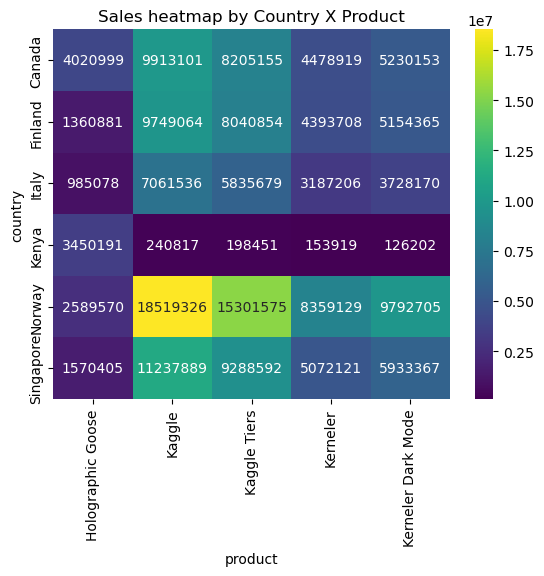

In [603]:
# check for the most sale location
heatmap_data = train_df.pivot_table(values="num_sold", index="country", columns="product", aggfunc="sum")

sns.heatmap(data=heatmap_data, cmap="viridis", annot=True, fmt=".0f")
plt.title("Sales heatmap by Country X Product")
plt.show()

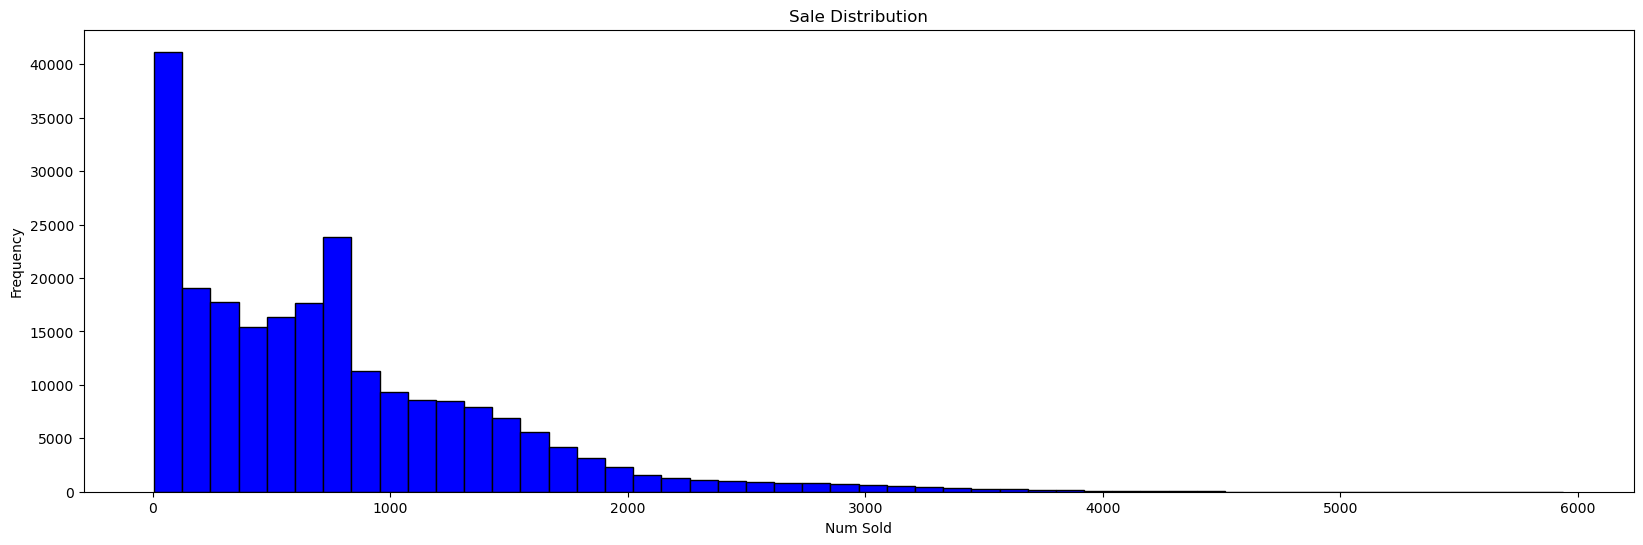

In [604]:
# Sale Distribution
plt.figure(figsize=(20, 6))
plt.hist(train_df["num_sold"], bins=50, color="blue", edgecolor="black")
plt.title("Sale Distribution")
plt.xlabel("Num Sold")
plt.ylabel("Frequency")
plt.show()

# Data feature engineering

In [605]:
# adding interaction features
def interaction_features(X):
    X["country_store"] = X["country"] + "_" + X["store"]
    X["country_product"] = X["country"] + "_" + X["product"]
    X["store_product"] = X["store"] + "_" + X["product"]
    X["store_country"] = X["store"] + "_" +  X["country"]
    return X

# convert timestamp data into numerical data
def calculate_week_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(np.ceil(adjusted_dom / 7.0))

def date_encoder(X):
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["weekOfMonth"] = X["date"].apply(calculate_week_month)
    X["dayOfWeek"] = X["date"].dt.dayofweek
    X["dayOfWeekSin"] = np.sin(2 * np.pi * X["dayOfWeek"] / 7)
    X["dayOfWeekCos"] = np.cos(2 * np.pi * X["dayOfWeek"] / 7)
    X = X.drop(columns=["date"])
    return X

# convert categorical data into numerical data
label = LabelEncoder()
def categorical_encoder(X):
    columns = ["country", "store", "product", "country_store", "country_product", "store_product", "store_country"]
    for col in columns:
        X[col] = label.fit_transform(X[col])
    return X

# removing unnecessary columns
train_df_encoded = train_df.drop(columns=["id", "num_sold"])
test_df_encoded = test_df.drop(columns=["id"])

# apply all the data feature engineering
train_df_encoded = interaction_features(train_df_encoded)
train_df_encoded = date_encoder(train_df_encoded)
train_df_encoded = categorical_encoder(train_df_encoded)

test_df_encoded = interaction_features(test_df_encoded)
test_df_encoded = date_encoder(test_df_encoded)
test_df_encoded = categorical_encoder(test_df_encoded)

train_df_encoded["num_sold"] = train_df["num_sold"]
train_df_encoded

,country,store,product,country_store,country_product,store_product,store_country,year,month,weekOfMonth,dayOfWeek,dayOfWeekSin,dayOfWeekCos,num_sold
0,0,0,0,0,0,0,0,2010,1,1,4,-0.433884,-0.900969,752.527382
1,0,0,1,0,1,1,0,2010,1,1,4,-0.433884,-0.900969,973.000000
2,0,0,2,0,2,2,0,2010,1,1,4,-0.433884,-0.900969,906.000000
3,0,0,3,0,3,3,0,2010,1,1,4,-0.433884,-0.900969,423.000000
4,0,0,4,0,4,4,0,2010,1,1,4,-0.433884,-0.900969,491.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,5,1,0,16,25,5,11,2016,12,5,5,-0.974928,-0.222521,466.000000
230126,5,1,1,16,26,6,11,2016,12,5,5,-0.974928,-0.222521,2907.000000
230127,5,1,2,16,27,7,11,2016,12,5,5,-0.974928,-0.222521,2299.000000
230128,5,1,3,16,28,8,11,2016,12,5,5,-0.974928,-0.222521,1242.000000


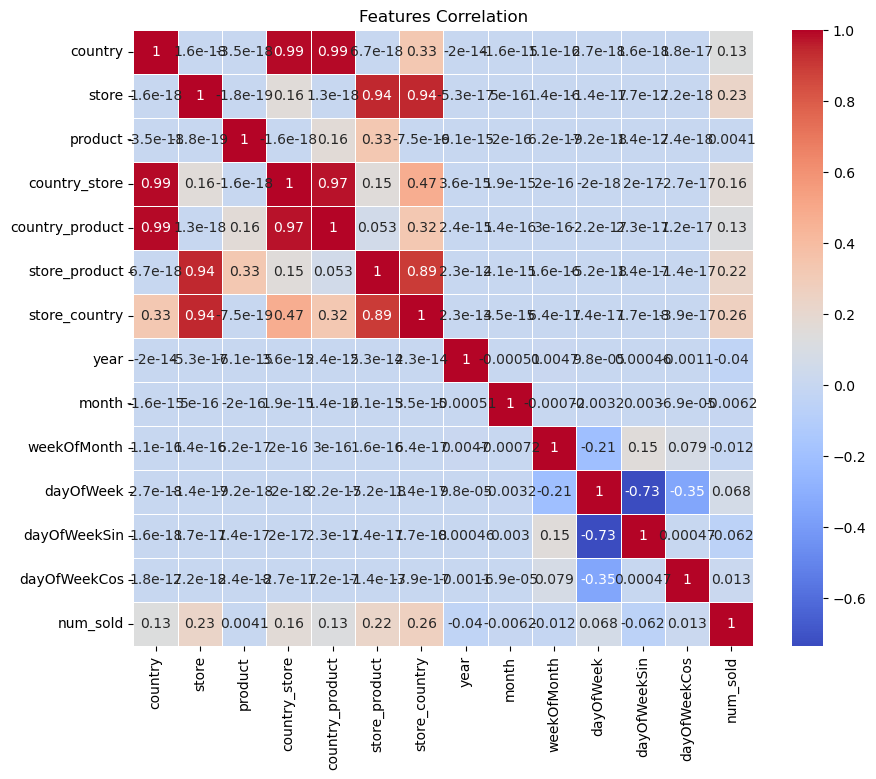

In [606]:
# check all features correlation after data converting
corr = train_df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, cmap="coolwarm", linewidths=0.5, annot=True)
plt.title("Features Correlation")
plt.show()

# Train model

In [607]:
# first we must to split data
X = train_df_encoded.drop(columns=["num_sold"])
y = np.log(train_df_encoded["num_sold"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(184104, 13)

In [608]:
test_df_encoded.shape

(98550, 13)

In [609]:
# train and valuate model
model = lgbm.LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
loss_mse = mean_squared_error(y_pred, y_val)
print(f"loss mse {loss_mse}")
loss_mape = mean_absolute_percentage_error(y_pred, y_val)
print(f"mape loss {loss_mape}")
prediction = np.sum(np.abs((y_val - y_pred) / y_val) <= 0.05)
print(f"Total {len(y_val)} and correct {prediction}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 13
[LightGBM] [Info] Start training from score 5.951563
loss mse 0.04976171141937034
mape loss 0.01822642528815439
Total 46026 and correct 44052


In [610]:
# creating submission.csv and submit to kaggle
y_pred_kaggle = pd.DataFrame()
y_pred_kaggle["id"] = test_df["id"]
y_pred_kaggle["num_sold"] = model.predict(test_df_encoded)

y_pred_kaggle.to_csv("submission.csv", index=False)
y_pred_kaggle

,id,num_sold
0,230130,6.629070
1,230131,6.663093
2,230132,6.496658
3,230133,5.847292
4,230134,6.094960
...,...,...
98545,328675,5.719341
98546,328676,7.636601
98547,328677,7.468020
98548,328678,6.953291
